## Train Model - Card Default Prediction 

In this notebook, a model will be created that predicts wheter the loan in question will default in the following 12 months, using the previously explored dataset

## 0. Import Functions and Preprocess data

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plot
import matplotlib.pyplot as pyplot

import sklearn
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold # for cross validation
from sklearn.model_selection import GridSearchCV # for tuning parameter
from sklearn.model_selection import RandomizedSearchCV  # Randomized search on hyper parameters.
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

#Import functions from the DataProcessing.py file
from DataProcessing import *

In [2]:
path_to_dataset_original = "../Dataset/exercise_syn_data_original.csv"
original_dataset = pd.read_csv(path_to_dataset_original, sep = ";", decimal=",")
seed = 42 # Seed for to unsure random processes are reproducible

In [3]:
processed_dataset = ReplaceNullValues(original_dataset) #Replace Unknown values (-1, -999) with NaNs
processed_dataset = totalTransactionsColumn(processed_dataset) #Sum all columns of type "amount_transaction_typeX" to obtain the total amount spent 
processed_dataset = oneHotEncode(processed_dataset)  #One-hot encode the LivingStatus and EmploymentStatus columns
processed_dataset = fillNaMean(processed_dataset) # Fill NaN values with the mean value for that specific feature
processed_dataset = processed_dataset.drop(labels = ['EmploymentStatus', 'LivingStatus'], axis = 1) # columns no longer needed

# Create new variable for all jobs, except the executive exmployee
processed_dataset['Stable_Job'] = processed_dataset['Civil servants/governmental'] + processed_dataset['Employee'] + processed_dataset['Executive civil servant']

## 1. Data Processing

- Divide Data into X and Y (features and target)
- Split data into training data and testing data (80% / 20 %). Use stratify using target variable

In [4]:
X = processed_dataset.drop('default', axis=1)  
y = processed_dataset['default']

X_train_, X_test_, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=seed)

- Two datasets are created, with diferent features. 
- The first features were selected with the findings from the DataExploration in mind. Features with most impact in the default probability and without unexpected behaviours were chosen.
- In the second data set, the features from the first dataset were selected, plus the amount_transaction_type features. 

In [5]:
column_list1 = ['MonthlyIncome' ,'external_score_1','time_to_first_trx', 'Student', 'Retiree/pensioner',  'Stable_Job',  'Owner', 'total_amount_transaction']
#'UnknownEmployment', 'Unemployed, 'Executive civil servant'
column_list2 = ['MonthlyIncome' ,'external_score_1', 'external_score_2' ,'time_to_first_trx', 'Student', 'Retiree/pensioner',  'Stable_Job',  'Owner', 'total_amount_transaction'] + [ ('amount_transaction_type'+ str(x+1)) for x in range(16)] 

X_train1 = X_train_[column_list1]
X_test1 = X_test_[column_list1]

X_train2 = X_train_[column_list2]
X_test2 = X_test_[column_list2]

In [6]:
display(X_train1.describe())
display(X_test1.describe())

,MonthlyIncome,external_score_1,time_to_first_trx,Student,Retiree/pensioner,Stable_Job,Owner,total_amount_transaction
count,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2108.685632,488.598754,89.32350,0.033500,0.094250,0.436250,0.274000,-341.657325
std,779.862204,73.954539,169.02661,0.179961,0.292213,0.495981,0.446065,574.800031
min,1000.000000,250.000000,9.00000,0.000000,0.000000,0.000000,0.000000,-7905.120000
25%,1500.000000,464.000000,25.00000,0.000000,0.000000,0.000000,0.000000,-446.452500
50%,2000.000000,499.000000,39.00000,0.000000,0.000000,0.000000,0.000000,-108.095000
75%,2500.000000,540.000000,71.00000,0.000000,0.000000,1.000000,1.000000,-14.775000
max,6001.000000,637.000000,1686.00000,1.000000,1.000000,1.000000,1.000000,0.000000


,MonthlyIncome,external_score_1,time_to_first_trx,Student,Retiree/pensioner,Stable_Job,Owner,total_amount_transaction
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2140.801722,487.794684,85.341000,0.02900,0.087000,0.443000,0.271000,-326.941850
std,809.711998,74.119790,157.110396,0.16789,0.281976,0.496989,0.444699,575.456767
min,1000.000000,253.000000,11.000000,0.00000,0.000000,0.000000,0.000000,-7115.580000
25%,1500.000000,468.000000,25.000000,0.00000,0.000000,0.000000,0.000000,-400.585000
50%,2000.000000,497.500000,38.500000,0.00000,0.000000,0.000000,0.000000,-125.155000
75%,2500.000000,539.000000,69.250000,0.00000,0.000000,1.000000,1.000000,-13.527500
max,6001.000000,637.000000,1384.000000,1.00000,1.000000,1.000000,1.000000,0.000000


- Oversampling: Defaults are a minority class in the dataset. If we wish to improve the model performance in this, oversampling techniques like SMOTE provide a way to increase the representation of default data.
- A sampling strategy of 0.20 was used, increasing the representation of default data from 4.6 % to 20 %

In [7]:
sm = SMOTE(sampling_strategy = 0.20, random_state=seed)
X_res1, y_res1 = sm.fit_resample(X_train1, y_train)

sm = SMOTE(sampling_strategy = 0.20, random_state=seed)
X_res2, y_res2 = sm.fit_resample(X_train2, y_train)

## 2. Model training and evaluation

Here we create the predicative model, considering the following:

Models tested :
- Decision Tree
- Logistic Regression
- Random Forest
- XGB Classifier

Datasets:
- Dataset1 was used for the DecisionTree and Logistic Regression models, since these are more simple models.
- Dataset2 was used for the Random Forest and the XGB Classifier. Because these models are more complex, they are able to handle better the high number of features given to the model.

Model training
- As mentioned before, data was split in train and test data. All models were trained in the training data and tested in the testing data.
- On top of that, hyperparameter tuning was performed in the training data, in order to choose the most adequate hyperparameters for each model. Stratified K Fold strategy was used for this purpose, with 5 splits.

Evaluation Metrics:
- Since we are doing a classification task, it would be tempting to evalute models using the accuracy metric. However, in this situation, we are doing Imbalanced Classification. We will use the AUC-ROC metric, since it measures the ability of the model to distinguish between default or no-default loans.

Model Parameters:
- All models presented some level of overfitting to the data. Because of this, strong regularization parameters were used.
- Despite we are oversampling default data, there is still some Imbalancing in the training data. Because of this, a higher class weight for the default class was used, so that the misclassification made in the minority class is more penalized. 

## 2.1 Decision Tree Classifier
- Dataset1 was used
- Grid Search method was used to search hyperparameters
- ROC AUC achieved: 0.84

In [8]:
model = DecisionTreeClassifier(random_state= seed)
skf = StratifiedKFold(n_splits=5, shuffle= True, random_state= seed)

param_grid = {"max_depth": [1,2 ,3, 4, 5],
              "max_features": [1,3 ,5],
              "min_samples_leaf": [3, 5 , 8, 10],
              "criterion": ['gini', 'entropy'],
              "class_weight" : [{0:1, 1:5}, {0:1, 1:10}, {0:1, 1:25}]
             
              }

best_model = GridSearchCV(estimator= model, param_grid= param_grid, 
                         cv= skf, verbose= True, n_jobs= -1, scoring = 'roc_auc')

best_model.fit(X_res1, y_res1)
print(best_model.best_score_)
print(best_model.best_params_)

y_pred_prob = best_model.predict_proba(X_test1)
print(sklearn.metrics.roc_auc_score(y_test, y_pred_prob[:,1] ))

y_pred = best_model.predict(X_test1)
print(classification_report(y_test, y_pred ))

#{'class_weight': {0: 1, 1: 10}, 'criterion': 'gini', 'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 8}
#ROC AUC: 0.8344954881050041

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
0.8463835429552475
{'class_weight': {0: 1, 1: 10}, 'criterion': 'gini', 'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 8}
0.8344954881050041
              precision    recall  f1-score   support

           0       1.00      0.64      0.78       954
           1       0.11      0.93      0.20        46

    accuracy                           0.65      1000
   macro avg       0.55      0.79      0.49      1000
weighted avg       0.95      0.65      0.75      1000



## 2.2 Logistic Regression
- Dataset1 was used
- Grid Search method was used to search hyperparameters
- ROC AUC achieved: 0.79

In [282]:
LRModel = LogisticRegression(random_state=seed)
skf = StratifiedKFold(n_splits=5, shuffle= True, random_state= seed)

param_grid = {'C': np.logspace(-5, 3, 15), 
              'solver': ['liblinear', 'newton-cg'],
              "class_weight" : ['balanced']
             }

best_model = GridSearchCV(estimator= LRModel, param_grid= param_grid, 
                         cv= skf, verbose= False, n_jobs= -1, scoring = 'roc_auc')

best_model.fit(X_res1, y_res1)
print(best_model.best_score_)
print(best_model.best_params_)

y_pred_prob = best_model.predict_proba(X_test1)
print(sklearn.metrics.roc_auc_score(y_test, y_pred_prob[:,1] ))

y_pred = best_model.predict(X_test1)
print(classification_report(y_test, y_pred ))

#{'C': 1.389495494373136, 'class_weight': 'balanced', 'solver': 'liblinear'}
#ROC AUC: 0.79

0.8361232727438311
{'C': 1.389495494373136, 'class_weight': 'balanced', 'solver': 'liblinear'}
0.7884878315559202
              precision    recall  f1-score   support

           0       0.98      0.71      0.83       954
           1       0.11      0.76      0.20        46

    accuracy                           0.71      1000
   macro avg       0.55      0.74      0.51      1000
weighted avg       0.94      0.71      0.80      1000



## 2.3 Random Forest Classifier
- Dataset2 was used
- Randomized Search method was used to search hyperparameters
- ROC AUC achieved: 0.878

In [309]:
model = RandomForestClassifier(random_state = seed, class_weight = 'balanced')
skf = StratifiedKFold(n_splits=5, shuffle= True, random_state= seed)

param_grid = {'n_estimators': [20, 30, 40, 60],
               "max_features": [2,3,4,5, 6, 7],
               'max_depth': [1,2,3,4, 5, 6, 7],
               "min_samples_leaf": [ 5, 10, 20 , 30 ],
               "criterion": [ "entropy", "gini"] ,}

best_model = RandomizedSearchCV(estimator= model, param_distributions= param_grid, cv= skf, verbose= True, n_jobs= -1, scoring = 'roc_auc', random_state=seed)

best_model.fit(X_res2, y_res2)
print(best_model.best_score_)
print(best_model.best_params_)

y_pred_prob = best_model.predict_proba(X_test2)
print(sklearn.metrics.roc_auc_score(y_test, y_pred_prob[:,1] ))

y_pred = best_model.predict(X_test2)
print(classification_report(y_test, y_pred ))


#{'n_estimators': 40, 'min_samples_leaf': 10, 'max_features': 7, 'max_depth': 6, 'criterion': 'gini'}
#Score: 0.877

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.9305064863544
{'n_estimators': 40, 'min_samples_leaf': 10, 'max_features': 7, 'max_depth': 6, 'criterion': 'gini'}
0.877768662838392
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       954
           1       0.18      0.76      0.29        46

    accuracy                           0.83      1000
   macro avg       0.58      0.80      0.59      1000
weighted avg       0.95      0.83      0.87      1000



## 2.4 XGB Classifier
- Dataset2 was used
- Randomized Search method was used to search hyperparameters
- ROC AUC achieved: 0.88

In [10]:
model = XGBClassifier(random_state = seed, scale_pos_weight =  5)
skf = StratifiedKFold(n_splits=5, shuffle= True, random_state= seed)


param_grid = {
    'n_estimators': [ 20, 30 , 40 ],
    'learning_rate': [0.01 , 0.05, 0.1 ],
    'max_depth' : [3, 5, 7, 10, 20],
    'gamma': [20 , 30, 50],
    'reg_alpha': [1, 5, 10],
    'reg_lambda': [5, 10],
}

#best_model = GridSearchCV(estimator= model, param_grid= param_grid, cv= skf, verbose= True, n_jobs= -1, scoring = 'roc_auc')
best_model = RandomizedSearchCV(estimator= model, param_distributions= param_grid, cv= skf, verbose= True, n_jobs= -1, scoring = 'roc_auc', random_state=seed)

best_model.fit(X_res2, y_res2)
print(best_model.best_score_)
print(best_model.best_params_)

y_pred_prob = best_model.predict_proba(X_test2)
print(sklearn.metrics.roc_auc_score(y_test, y_pred_prob[:,1] ))

y_pred = best_model.predict(X_test2)
print(classification_report(y_test, y_pred ))

#best : {'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 40, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 20}
# ROC: 0.88

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.9493388253418219
{'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 40, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 20}
0.8800246103363413
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       954
           1       0.17      0.57      0.27        46

    accuracy                           0.86      1000
   macro avg       0.58      0.72      0.59      1000
weighted avg       0.94      0.86      0.89      1000



## Model Choice

The XGBoost classifier is the model chosen for loan default prediction. We use the power of Gradient Boosting to create this model, with strong regularization parameters. Model was trained in data which was oversampled in the default loan data. Higher class weights values for the default class were used, so that the misclassification made in the minority class is more penalized.

Here are the characteristics of this model

Model features:
-  'MonthlyIncome' ,'external_score_1', 'external_score_2' ,'time_to_first_trx', 'Student', 'Retiree/pensioner',  'Stable_Job',  'Owner', 'total_amount_transaction', 'amount_transaction_typeX'

Model Hyperparameters:
- 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 40, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 20, 'scale_pos_weight' =  5

Evalutation Metrics:
- Train ROC AUC: 0.95
- Test ROC AOC: 0.88

Classification Report:

                       precision recall   f1-score  count

         0   0         0.98      0.87      0.92       954
         0   1         0.17      0.57      0.27        46

         macro avg     0.58      0.72      0.59      1000
    
         weighted av   0.94      0.86      0.89      1000
         
Overall, a very good ROC AUC score was achieved. The model performs better in classifying non-defaults than default loans. It was also possible to achieve a precision of 99 %, which means that we can be very confident of the non-default predictions made by the model.

0.8800246103363413


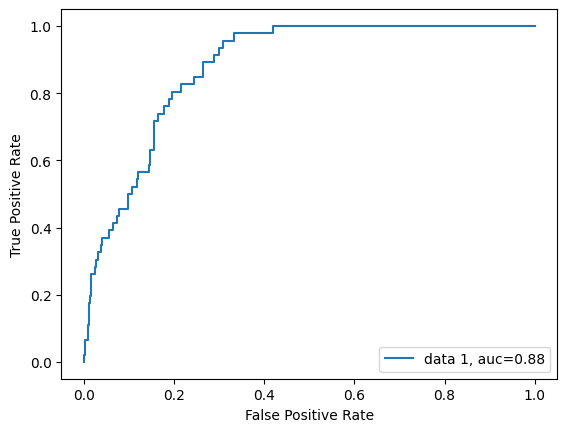

In [11]:
y_pred = best_model.predict_proba(X_test2)
print(sklearn.metrics.roc_auc_score(y_test, y_pred[:,1] ))


fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred[:,1] )
auc = sklearn.metrics.roc_auc_score(y_test, y_pred[:,1])
pyplot.plot(fpr,tpr,label="data 1, auc="+str(round(auc, 2)))
pyplot.xlabel('False Positive Rate') 
pyplot.ylabel('True Positive Rate') 
pyplot.legend(loc=4)
pyplot.show()